# Vectorizers on Hypergraphs

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text
import sklearn.preprocessing
import scipy.sparse
import vectorizers
import vectorizers.transformers
import umap
import umap.plot
import pynndescent
import seaborn as sns
import matplotlib.colors
import warnings
from bokeh.plotting import show
from sklearn.metrics import adjusted_rand_score

umap.plot.output_notebook()
warnings.simplefilter("ignore")
sns.set()


Loading BokehJS ...

# Running the same analysis on Cooking hypergraph

* https://arxiv.org/pdf/1910.09943.pdf
* https://www.kaggle.com/c/whats-cooking

The cooking hypergraph is a set of ingredients from recipes.

In [5]:
execfile('./00-recipes-setup.py')
recipes, recipes_label_id, ingredients_id, label_name, color_key = read_format_recipes()

In [6]:
recipes_label = [label_name.loc[i]['new_label'] for i in recipes_label_id.label]
labels = np.array(recipes_label_id.label.tolist())

In [7]:
H_vectorizer = vectorizers.NgramVectorizer(
).fit(recipes)

H = H_vectorizer.transform(recipes)
print(H.shape)

edge_sizes = np.array(H.sum(axis=1).T.tolist()[0])
node_degrees = np.array(H.sum(axis=0).tolist()[0])

(39559, 6709)


In [38]:
print(f'{len(recipes)} recipes')
print(f'made of {len(ingredients_id)} ingredients')
print(f'from {len(label_name)} countries')

39559 recipes
made of 6714 ingredients
from 20 countries


In [9]:
ingredients_id.head(4)

Ingredient
1  ginger paste
2      sea salt
3    shortbread
4     chocolate

In [10]:
label_name.head(4)

country         new_label
1      korean      asian.korean
2     russian    others.russian
3  vietnamese  asian.vietnamese
4    filipino    asian.filipino

# Hypergraph statistics

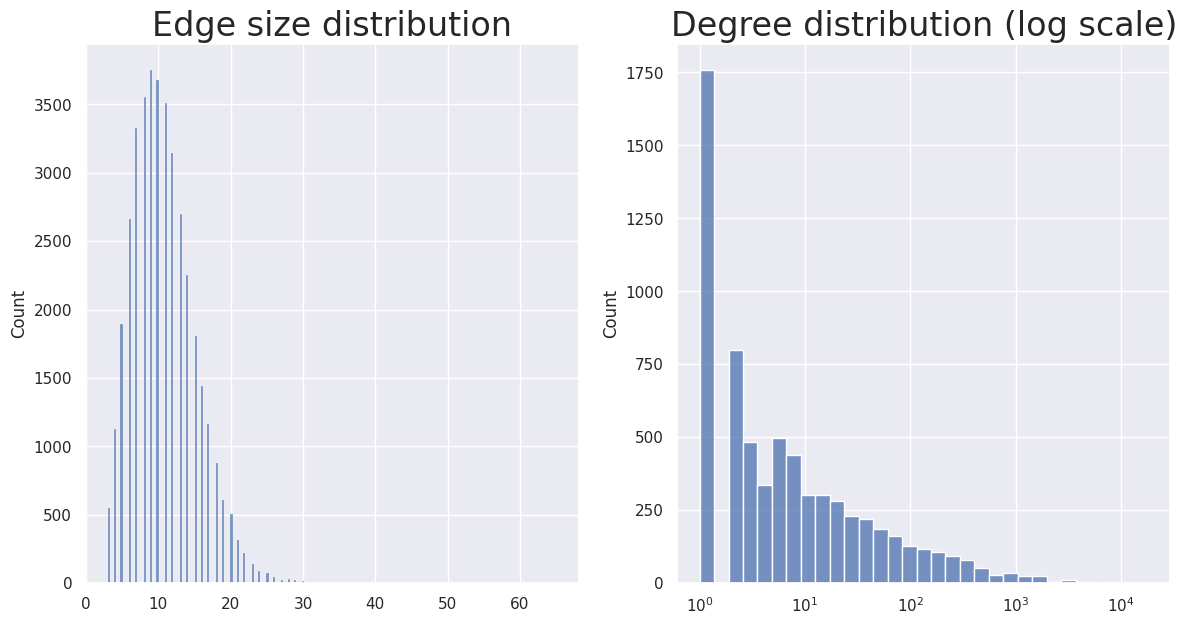

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

axs[0].set_title("Edge size distribution", fontsize=24)
sns.histplot(edge_sizes, ax=axs[0])

axs[1].set_title("Degree distribution (log scale)", fontsize=24)
sns.histplot(node_degrees, ax=axs[1], log_scale=True)
fig.savefig('figures/recipe_degree_edgesize_dists.png')

### Popular ingredients : high degree nodes

In [12]:
[H_vectorizer.column_index_dictionary_[x] for x in np.where(node_degrees>5000)[0]]

['garlic', 'garlic cloves', 'olive oil', 'onions', 'salt', 'sugar', 'water']

# Vectorize Ingredients (nodes)
We have to use a different version if we don't want hyperedge to be split between "before" and "after" the way it is through tokenCooccurrenceVectorizer.

In [13]:
%%time
long_list = max(len(x) for x in recipes)
ingredient_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=1,
    window_radii=long_list,          
    window_functions='fixed',
    kernel_functions='flat',            
    n_iter = 0,
    normalize_windows=True,
).fit(recipes)

# ingredient_vectorizer = vectorizers.MultiSetCooccurrenceVectorizer(
#         window_radii=0,
#         window_orientations='before',
#         normalize_windows=True,
#         n_iter = 0
#     ).fit([recipes])

ingredient_vectors = ingredient_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")

CPU times: user 14.8 s, sys: 550 ms, total: 15.4 s
Wall time: 13.3 s


In [39]:
%%time
ingredient_mapper = umap.UMAP(n_neighbors=8, random_state=42).fit(ingredient_vectors)

CPU times: user 29.1 s, sys: 5.91 s, total: 35.1 s
Wall time: 6.79 s


In [40]:
hover_data=pd.DataFrame()
hover_data['vocab'] = [ingredient_vectorizer.token_index_dictionary_[x] for x in range(len(ingredient_vectorizer.token_index_dictionary_))]

p = umap.plot.interactive(
    ingredient_mapper, 
    hover_data=hover_data, 
    point_size=5, 
    values=np.log(ingredient_vectorizer._token_frequencies_), 
    interactive_text_search=True, 
    interactive_text_search_alpha_contrast=0.99)
show(p)

----
## Recipe Embedding

There are 3 steps to obtain the Approximate Wasserstein recipe embedding: 
1. **Hyperedge (bag-of-ingredient) Embedding** via `NgramVectorizer`: This step uses a bag-of-words approach to vectorize documents. 
2. **Information Weight Embedding** via `InformationWeightTransformer`: This step takes an information theoretic view to generating feature weights for count data (inspired by TF-IDF). 
3. **Approximate Wasserstein Embedding (AWE)** via `ApproximateWassersteinVectorizer`: This step takes into account the fact that our ingredients are not independent of each other and have similarities (interchangeability) should be treated as distributions in their own right. This is a linear algebra approximation to the Wasserstein Embedding (WE) (aka. the fast way to do WE).


In [16]:
%%time
bow_recipe_vectors = vectorizers.NgramVectorizer(
    token_dictionary=ingredient_vectorizer.token_label_dictionary_
).fit_transform(recipes)

CPU times: user 1.71 s, sys: 47.9 ms, total: 1.75 s
Wall time: 1.75 s


In [17]:
bow_recipe_mapper = umap.UMAP(metric="hellinger", random_state=42).fit(bow_recipe_vectors)

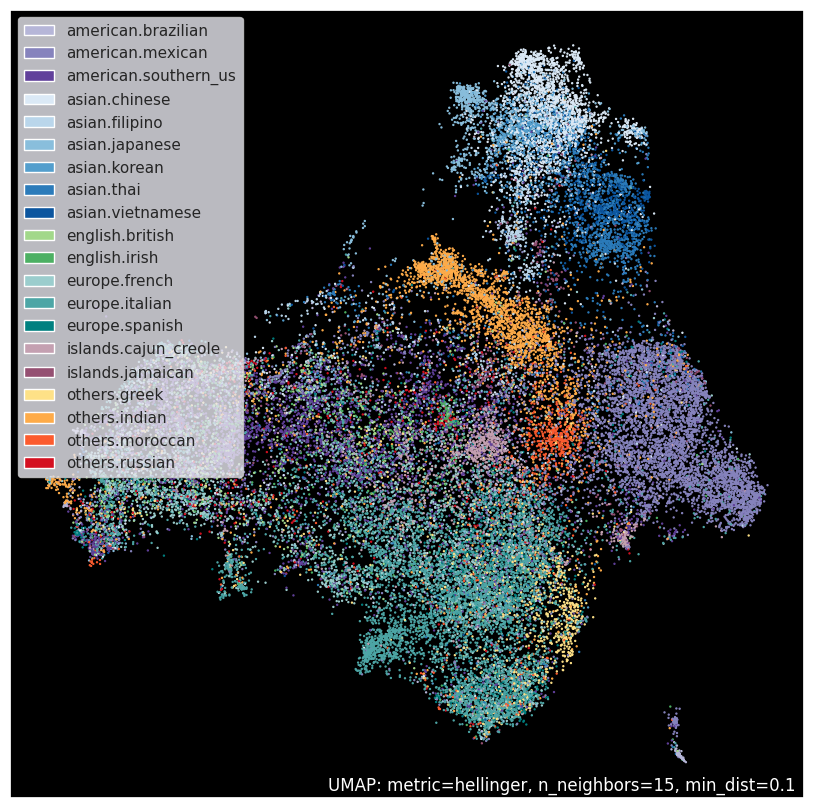

In [18]:
umap.plot.points(
    bow_recipe_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
);

In [19]:
%%time
# in terms of degrees?
info_transformer = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
)
info_recipe_vectors = info_transformer.fit_transform(bow_recipe_vectors)

CPU times: user 12 s, sys: 372 ms, total: 12.3 s
Wall time: 1.73 s


In [20]:
%%time
info_recipe_mapper = umap.UMAP(metric="cosine", random_state=42).fit(info_recipe_vectors)

CPU times: user 20min 1s, sys: 51 s, total: 20min 52s
Wall time: 50 s


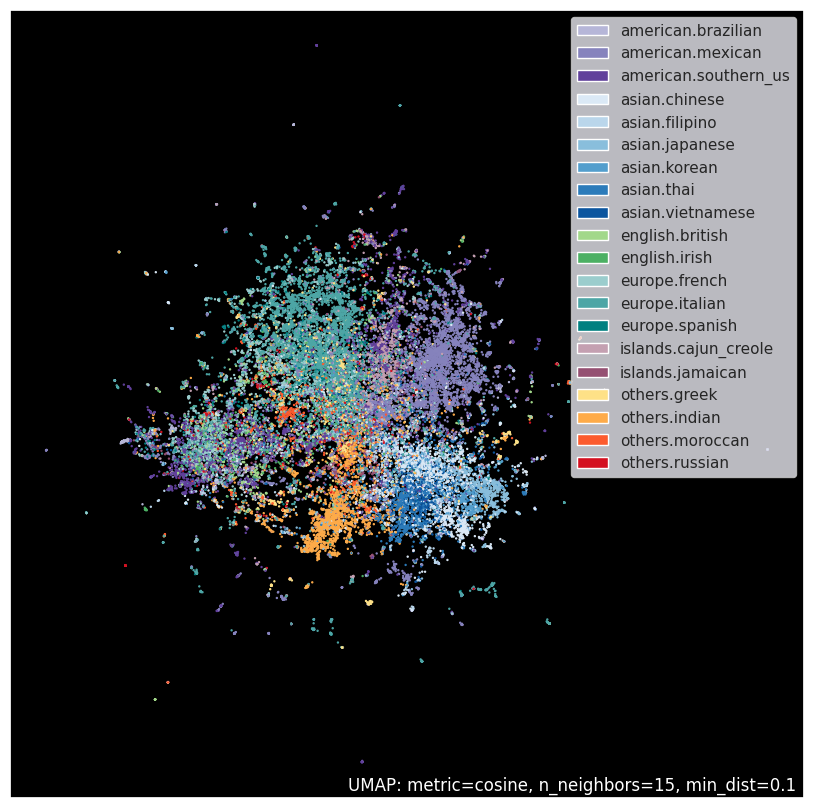

In [21]:
import matplotlib._color_data as mcd
palette = list(mcd.XKCD_COLORS.values())[::20]

umap.plot.points(
    info_recipe_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
);

In [22]:
%%time
awe_recipe_vectorizer = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
)
awe_recipe_vectors = awe_recipe_vectorizer.fit_transform(info_recipe_vectors, vectors=ingredient_vectors)

CPU times: user 9.01 s, sys: 684 ms, total: 9.69 s
Wall time: 341 ms


In [23]:
%%time
awe_doc_mapper = umap.UMAP(metric="cosine", random_state=42).fit(awe_recipe_vectors)

CPU times: user 1min 53s, sys: 56.5 s, total: 2min 50s
Wall time: 25.7 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


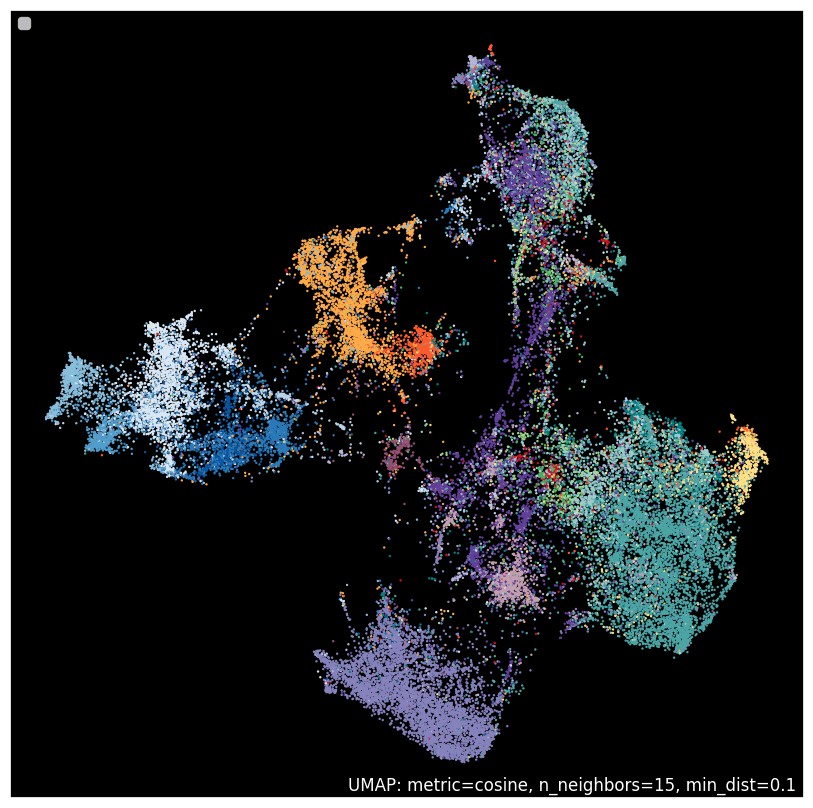

In [24]:
p = umap.plot.points(
    awe_doc_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
);
p.legend(loc='upper left')

In [25]:
umap_4_cluster = umap.UMAP(n_neighbors=15, n_components=8, random_state=42)
M_mapper_cl_1 = umap_4_cluster.fit(awe_recipe_vectors)
hdbscan_labels_1 = hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(M_mapper_cl_1.embedding_)

print(sum(hdbscan_labels_1!=-1))
adjusted_rand_score(hdbscan_labels_1[hdbscan_labels_1!=-1], labels[hdbscan_labels_1!=-1])

24959


0.5233954891722536

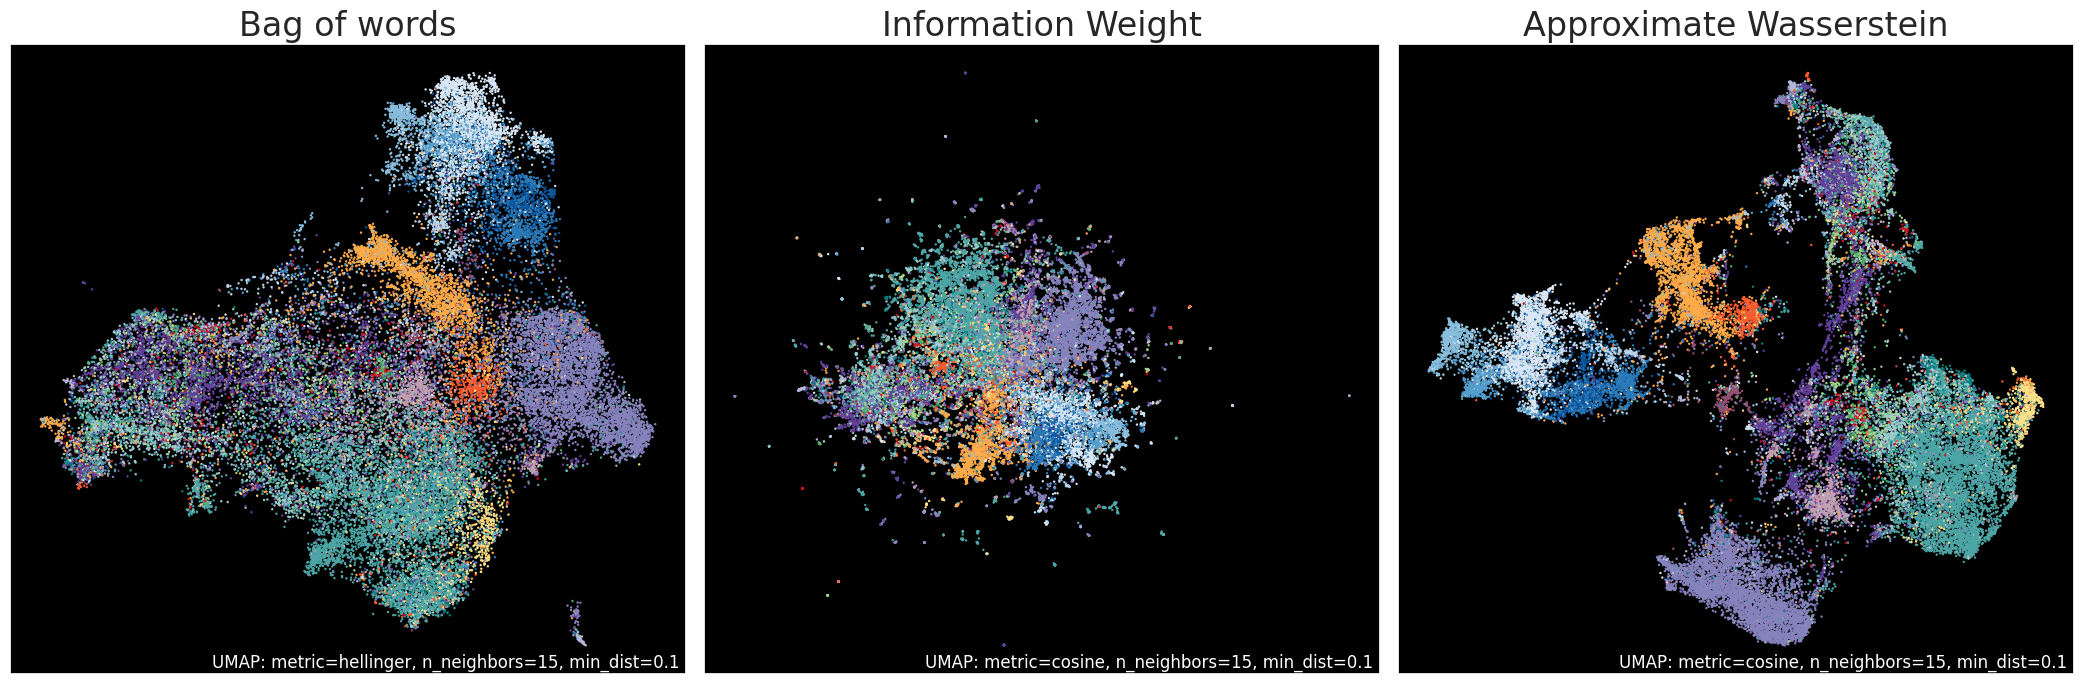

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21,7))

axs[0].set_title("Bag of words", fontsize=24)
umap.plot.points(
    bow_recipe_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
    ax=axs[0],
    show_legend=False,
    
);

axs[1].set_title("Information Weight", fontsize=24)
umap.plot.points(
    info_recipe_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
    ax=axs[1],
    show_legend=False,
);

axs[2].set_title("Approximate Wasserstein", fontsize=24)
p = umap.plot.points(
    awe_doc_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
    ax=axs[2],
    show_legend=False,
);
fig.tight_layout()
plt.show()
fig.savefig('figures/recipe_bow_info_awe.png')

In [27]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,1) #create the axes
# ax.set_axis_off() #turn off the axis
# legend_label = [w.get_text() for w in list(p.legend_.get_texts())]
# ax.legend(handles = p.legend_.legendHandles, labels = legend_label) #legend alone in the figure
# fig.tight_layout()
# plt.show()
# fig.savefig('figures/recipe_bow_info_awe_legend.png')

### Simpler ways : straight from matrix transformation

In [30]:
from sklearn.utils.extmath import randomized_svd, svd_flip
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
def reduce_dimension(
        M,
        dimension=150,
        algorithm="arpack",
        n_iter=10,
        power=0.25,
    ):

        reduced_matrix_ = normalize(M, axis=0, norm="l1")
        reduced_matrix_ = normalize(reduced_matrix_, axis=1, norm="l1")

        reduced_matrix_.data = np.power(reduced_matrix_.data, power)

        if algorithm == "arpack":
            u, s, v = svds(reduced_matrix_, k=dimension)
        elif algorithm == "randomized":
            u, s, v = randomized_svd(
                reduced_matrix_, n_components=dimension, n_iter=n_iter
            )

        u, v = svd_flip(u, v)
        reduced_matrix_ = u * np.power(s, 0.5)

        return reduced_matrix_

In [28]:
edge_size = H.sum(axis=0).tolist()[0]
D_e = scipy.sparse.diags(edge_size, format='csc')
D_e_inv = scipy.sparse.diags([1/x if x>0 else 1 for x in edge_size], format='csc')

In [31]:
umap_4_plot = umap.UMAP(n_neighbors=20,  random_state=42)

M_norm_1 = (H@D_e_inv**2@H.T)
# M_norm_1.setdiag(0)
# M_norm_1.eliminate_zeros()
M_norm_red_1 = reduce_dimension(M_norm_1, dimension=60, algorithm='randomized')

In [32]:
M_mapper_norm_1 = umap_4_plot.fit(M_norm_red_1)

In [33]:
p = umap.plot.interactive(
    M_mapper_norm_1, 
    labels=recipes_label,
    point_size=5, 
    #values=np.log(node_degrees), 
    interactive_text_search=True, 
    interactive_text_search_alpha_contrast=0.99)
show(p)

In [34]:
umap_4_cluster = umap.UMAP(n_neighbors=20, n_components=3, random_state=42)
M_mapper_cl_1 = umap_4_cluster.fit(M_norm_red_1)
hdbscan_labels_1 = hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(M_mapper_cl_1.embedding_)

print(sum(hdbscan_labels_1!=-1))
adjusted_rand_score(hdbscan_labels_1[hdbscan_labels_1!=-1], labels[hdbscan_labels_1!=-1])

21380


0.13290106136458082

# Co-occurences of edges

## Embedding recipes as cooccurrences

In [35]:
# Get the dual hypergraph as a list of lists
vertex_dict = dict()
for x in ingredients_id.Ingredient:
    vertex_dict[x] = []
for i, he in enumerate(recipes):
    for v in he:
        vertex_dict[v].append(i)

# The dual has one list per vertex
hyperedges = [vertex_dict[x] for x in ingredients_id.Ingredient ]

In [36]:
long_list = max(len(x) for x in hyperedges)
he_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
        window_radii=long_list,
        window_orientations='before',
        normalize_windows=True,
        n_iter = 0
    ).fit(hyperedges)
# vertex_vectorizer = TokenSetCooccurrenceVectorizer(hyperedges)
hyperedge_vectors = he_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")

In [ ]:
long_list = max(len(x) for x in hyperedges)

vertex_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=1,
    window_radii=long_list,          
    window_functions='fixed',
    kernel_functions='flat',            
    n_iter = 0,
    normalize_windows=True,
).fit(hyperedges)
vertex_vectors = vertex_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")

In [ ]:
%%time
vertex_mapper = umap.UMAP(n_neighbors=8, random_state=42).fit(vertex_vectors)

In [ ]:
p = umap.plot.points(
    vertex_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
);
p.legend(loc='upper left')